In [1]:
import src
import pyaldata
import yaml
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_context('talk')

%load_ext autoreload
%autoreload 2

In [2]:
with open('../params.yaml', 'r') as params_file:
    full_params = yaml.safe_load(params_file)
    lfads_params = full_params['lfads_prep']
    analysis_params = full_params['analysis']

trial_data = src.data.load_clean_data('../data/trial_data/Earl_20190716_COCST_TD.mat')
td_co = src.lfads_helpers.prep_data_with_lfads(trial_data, 'CO', lfads_params, analysis_params)
td_cst = src.lfads_helpers.prep_data_with_lfads(trial_data,'CST', lfads_params, analysis_params)

td_co = pyaldata.add_gradient(td_co,'lfads_pca',normalize=True)
td_cst = pyaldata.add_gradient(td_cst,'lfads_pca',normalize=True)
td_co = pyaldata.add_gradient(td_co,'M1_pca',normalize=True)
td_cst = pyaldata.add_gradient(td_cst,'M1_pca',normalize=True)

co_epoch_fun = src.util.generate_realtime_epoch_fun(
    'idx_goCueTime',
    rel_start_time=-1.0,
    rel_end_time=0.5,
)
cst_epoch_fun = src.util.generate_realtime_epoch_fun(
    'idx_goCueTime',
    rel_start_time=-1.0,
    rel_end_time=5.0,
)
td_co = pyaldata.restrict_to_interval(td_co,epoch_fun=co_epoch_fun)
td_cst = pyaldata.restrict_to_interval(td_cst,epoch_fun=cst_epoch_fun)

/home/raeed/miniconda3/envs/autolfads-tf2/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [  7   8  18  19  22  24  25  33  34  36  56  62  66  86  94  95 103 110
 112 115 120 123 131 137 139 146 157 159 161 162 165 173 181 187 200 218
 222 224 225 229 230 239 244 249 254 261 266 269 271 286 304 306 308 309
 316 321 334 342 344 347 351 352 355 357 360 361 366 369 370 371 373 376
 378 381 382 384 386 388 393 394 399 403 404 405 408 409 411 413 416 420
 422 423 424 426 427 428 429 431 436 437 446 447 452 454 456 458 459 460
 461 462 464 469 472 476 477 481 488 489 490 491 492 494 500 508 509 510
 512 513 516 519 534 535 536]
/home/raeed/miniconda3/envs/autolfads-tf2/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_p

In [3]:
td_co = src.data.add_trial_time(td_co,ref_event='idx_goCueTime')
df_co = src.util.crystallize_dataframe(td_co,sig_guide=['trialtime','M1_pca','dM1_pca','lfads_pca','dlfads_pca','lfads_inputs','rel_hand_pos','hand_vel','cursor_pos','cursor_vel'])
meta_co = src.util.extract_metaframe(td_co,metacols=['trial_id','tgtDir','tgtMag'])
df_co = df_co.join(meta_co,on='trial_id')
co_measures = pd.DataFrame(
    data = {
        'Time from go cue': df_co[('trialtime',0)],
        'Target direction': df_co[('tgtDir','tgtDir')],
        'Target magnitude': df_co[('tgtMag','tgtMag')],
        'X hand position': df_co[('rel_hand_pos',0)],
        'X hand velocity': df_co[('hand_vel',0)],
        'X cursor position': df_co[('cursor_pos',0)],
        'X cursor velocity': df_co[('cursor_vel',0)],
        'LFADS input norm': np.linalg.norm(df_co['lfads_inputs'],axis=1),
        'Smoothed tangling': src.dynamics.estimate_neural_tangling(df_co,x='M1_pca',dx='dM1_pca',num_sample_points=2500),
        'LFADS tangling': src.dynamics.estimate_neural_tangling(df_co,x='lfads_pca',dx='dlfads_pca',num_sample_points=2500),
    },
    index=df_co.index,
)

In [4]:
from ipywidgets import interact
@interact(co_trial_id=list(df_co.groupby('trial_id').groups.keys()))
def plot_trials(co_trial_id):
    trial = co_measures.groupby('trial_id').get_group(co_trial_id)

    x_vars = ['Time from go cue']
    y_vars = ['Smoothed tangling','LFADS tangling','LFADS input norm','X hand position']
    g=sns.PairGrid(
        trial[x_vars+y_vars],
        y_vars=y_vars,
        x_vars=x_vars,
        height=2,
        aspect=4,
    )

    g.map(sns.lineplot)

    for ax in g.axes.flatten():
        ax.plot([0,0],ax.get_ylim(),'k--')

    sns.despine(fig=g.figure,trim=True)


interactive(children=(Dropdown(description='co_trial_id', options=(11, 16, 17, 23, 40, 45, 47, 58, 59, 65, 69,…

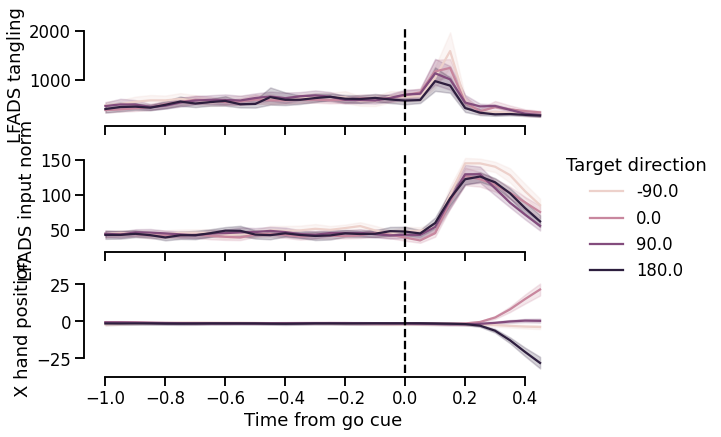

In [5]:
x_vars = ['Time from go cue']
y_vars = ['LFADS tangling','LFADS input norm','X hand position']
hue_var = 'Target direction'
style_var = 'Target magnitude'
g=sns.PairGrid(
    co_measures[x_vars+y_vars+[hue_var,style_var]],
    y_vars=y_vars,
    x_vars=x_vars,
    hue=hue_var,
    height=2,
    aspect=4,
)

g.map(sns.lineplot)
g.add_legend()

for ax in g.axes.flatten():
    ax.plot([0,0],ax.get_ylim(),'k--')

sns.despine(fig=g.figure,trim=True)


In [6]:
td_cst = src.data.add_trial_time(td_cst,ref_event='idx_goCueTime')
df_cst = src.util.crystallize_dataframe(td_cst,sig_guide=['trialtime','M1_pca','dM1_pca','lfads_pca','dlfads_pca','lfads_inputs','rel_hand_pos','hand_vel','rel_cursor_pos','cursor_vel'])
cst_measures = pd.DataFrame(
    data = {
        'Time from go cue': df_cst[('trialtime',0)],
        'X hand position': df_cst[('rel_hand_pos',0)],
        'X hand velocity': df_cst[('hand_vel',0)],
        'X cursor position': df_cst[('rel_cursor_pos',0)],
        'X cursor velocity': df_cst[('cursor_vel',0)],
        'LFADS input norm': np.linalg.norm(df_cst['lfads_inputs'],axis=1),
        'Smoothed tangling': src.dynamics.estimate_neural_tangling(df_cst,x='M1_pca',dx='dM1_pca',num_sample_points=2500),
        'LFADS tangling': src.dynamics.estimate_neural_tangling(df_cst,x='lfads_pca',dx='dlfads_pca',num_sample_points=2500),
    },
    index=df_cst.index,
)


In [7]:
# cst_measures_melt = pd.concat(
#     [
#         pd.DataFrame(
#             data = {
#                 'LFADS input norm': np.linalg.norm(df_cst['lfads_inputs'],axis=1),
#                 'X hand position': df_cst[('rel_hand_pos',0)],
#                 'X hand velocity': df_cst[('hand_vel',0)],
#                 'X cursor position': df_cst[('rel_cursor_pos',0)],
#                 'X cursor velocity': df_cst[('cursor_vel',0)],
#             },
#             index=df_cst.index,
#         ).melt(ignore_index=False,var_name='Name',value_name='Signal'),
#         pd.DataFrame(
#             data = {
#                 'Smoothed tangling': src.dynamics.rand_sample_tangling(num_samples=30,data=df_cst,x='M1_pca',dx='dM1_pca',num_sample_points=2500),
#                 'LFADS tangling': src.dynamics.rand_sample_tangling(num_samples=30,data=df_cst,x='lfads_pca',dx='dlfads_pca',num_sample_points=2500),
#             },
#         ).melt(ignore_index=False,var_name='Name',value_name='Signal')
#     ],
#     axis=0,
# )
# cst_measures_melt['Time from go cue'] = df_cst['trialtime'].squeeze().reindex(cst_measures.index)

# trial = cst_measures_melt.groupby('trial_id').get_group(313)
# g = sns.FacetGrid(
#     trial.reset_index(),
#     row='Name',
#     height=2,
#     aspect=4,
#     row_order=['Smoothed tangling','LFADS tangling','LFADS input norm','X hand position'],
#     sharey=False,
# )
# g.map(sns.lineplot,'Time from go cue','Signal')
# 
# for ax in g.axes.flatten():
#     ax.plot([0,0],ax.get_ylim(),'k--')
# 
# sns.despine(fig=g.figure,trim=True)

In [8]:
@interact(cst_trial_id=list(cst_measures.groupby('trial_id').groups.keys()))
def plot_trials(cst_trial_id):
    trial = cst_measures.groupby('trial_id').get_group(cst_trial_id)
    x_vars = ['Time from go cue']
    y_vars = ['LFADS tangling','LFADS input norm','X hand position','X hand velocity']
    g=sns.PairGrid(
        trial[x_vars+y_vars],
        y_vars=y_vars,
        x_vars=x_vars,
        height=2,
        aspect=4,
    )

    g.map(sns.lineplot)

    for ax in g.axes.flatten():
        ax.plot([0,0],ax.get_ylim(),'k--')

    sns.despine(fig=g.figure,trim=True)

interactive(children=(Dropdown(description='cst_trial_id', options=(1, 2, 3, 4, 5, 6, 9, 10, 12, 13, 14, 15, 2…

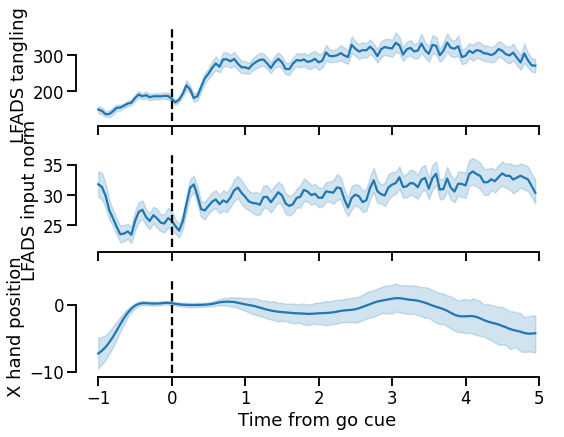

In [9]:
x_vars = ['Time from go cue']
y_vars = ['LFADS tangling','LFADS input norm','X hand position']
g=sns.PairGrid(
    cst_measures[x_vars+y_vars],
    y_vars=y_vars,
    x_vars=x_vars,
    height=2,
    aspect=4,
)

g.map(sns.lineplot)

for ax in g.axes.flatten():
    ax.plot([0,0],ax.get_ylim(),'k--')

sns.despine(fig=g.figure,trim=True)

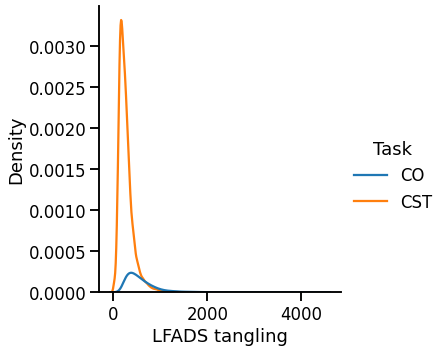

In [27]:
x_vars = ['Time from go cue','LFADS tangling','LFADS input norm','X hand position','X hand velocity']
cocst_tangling = pd.concat(
    [co_measures[x_vars],cst_measures[x_vars]],
    axis=0,
    keys=['CO','CST'],
)
cocst_tangling.index.rename('Task',level=0,inplace=True)
cocst_tangling
sns.displot(
    data=cocst_tangling,
    x='LFADS tangling',
    hue='Task',
    kind='kde',
)

## Quantification of tangling and LFADS inputs

It seems like tangling and high LFADS input precede large movements, as we might expect from a signal indicating the onset of some intermittent movement or adjustment. Let's try to uncover this relationship (if it's there).

First, let's just verify that tangling and LFADS input norm are highly correlated to start with.

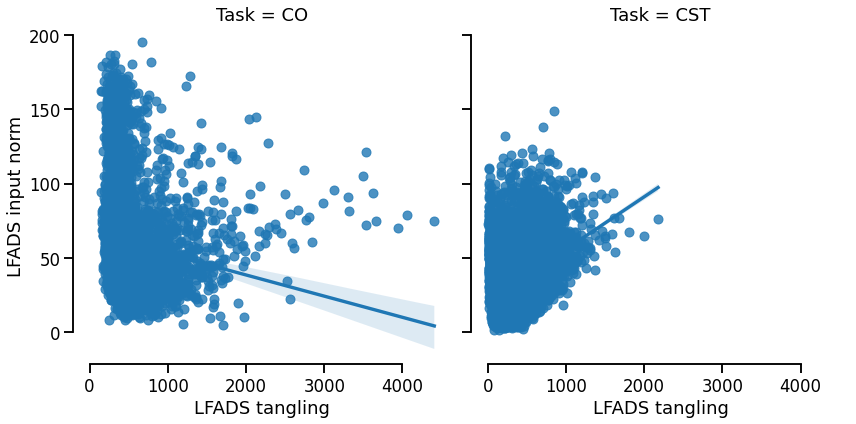

In [23]:
# sns.jointplot(
#     data=cocst_tangling,
#     x='LFADS tangling',
#     y='LFADS input norm',
#     col='Task',
#     kind='reg',
# )
g = sns.FacetGrid(
    data=cocst_tangling.reset_index(),
    col='Task',
    height=6,
    row_order=['CO','CST'],
)
g.map(sns.regplot,'LFADS tangling','LFADS input norm')
sns.despine(fig=g.figure,trim=True)

Hmm... not super convincing on the CO plot, but there does seem to be a bit of a bimodal distribution there. Let's try out a different plot to see if that's the case.

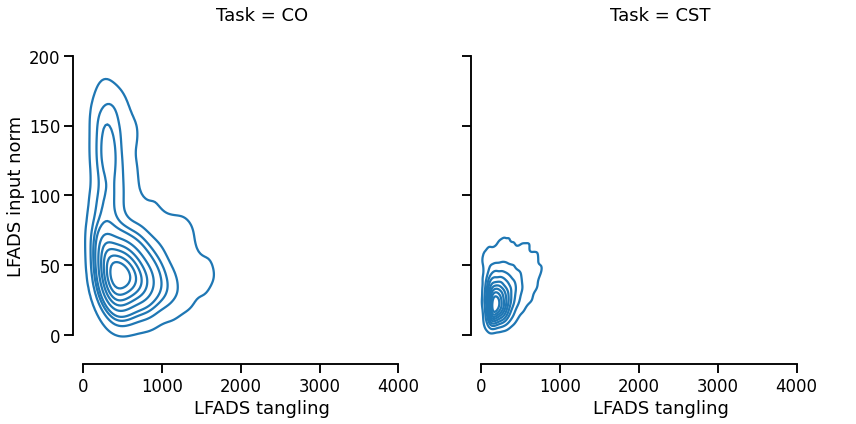

In [24]:
g = sns.FacetGrid(
    data=cocst_tangling.reset_index(),
    col='Task',
    height=6,
    row_order=['CO','CST'],
)
g.map(sns.kdeplot,'LFADS tangling','LFADS input norm')
sns.despine(fig=g.figure,trim=True)

I think there probably is some sort of bimodality in there with high LFADS input but low tangling that's throwing this whole thing off. Without that top lobe, tangling would probably correlate okay with LFADS input. What that top lobe of the distributional plot is, I'm not sure. But it's a problem for another time.

## Cross-correlation between tangling and hand speed

Let's move onto the cross-correlograms between tangling and horizontal hand speed! For this, we'll cross-correlate tangling and hand speed trial-by-trial and then average the cross-correlograms together.

Mechanistically, this involves grouping by `trial_id`, computing the cross-correlogram for each group (which results in its own DataFrame with index `(trial_id, Lag bin)`), and then concatenating all of those together. We can then plot the result using Seaborn pretty easily.

<AxesSubplot:xlabel='Lag', ylabel='Cross-correlation'>

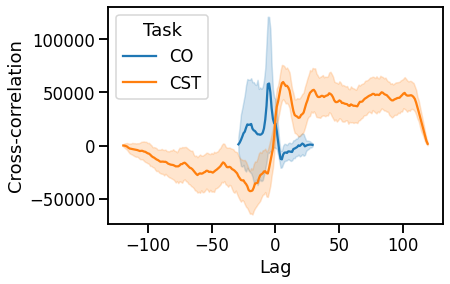

In [56]:
from scipy.signal import correlate, correlation_lags

tangling_vel_corr = (
    cocst_tangling.groupby(['Task','trial_id'])
    .apply(
        lambda s: pd.Series({
            'Cross-correlation': correlate(s['LFADS tangling'],(s['X hand velocity'])),
            'Lag': correlation_lags(len(s['LFADS tangling']),len(s['X hand velocity'])),
        })
    )
    .explode(column=['Cross-correlation','Lag'])
    .set_index('Lag',append=True)
)

sns.lineplot(
    data=tangling_vel_corr,
    x='Lag',
    y='Cross-correlation',
    hue='Task',
)

Well... I accidentally cross-correlated the tangling with the hand velocity instead of hand speed, and I found something kind of interesting. It seems as though the tangling is negatively correlated with previous hand velocities and positively correlated with future hand velocities (or vice versa--I haven't figured out what positive lag means here yet). I suppose this means that at points of high tangling there's a sharp autocorrelation in the hand velocity signal? Because normally I would expect hand velocity autocorrelation to be quite wide, which would mean that this kind of result shouldn't be happening. But if tangling indicates some sort of change point in hand velocity (i.e. it happens right as monkeys change direction), then maybe this is what I would expect. But only if it indicated monkeys changing direction in a signed way, i.e. acceleration specifically to the right (or left--again, haven't figured out the signs here yet).

Anyway, here's the actual thing I originally wanted to plot:

<AxesSubplot:xlabel='Lag', ylabel='Cross-correlation'>

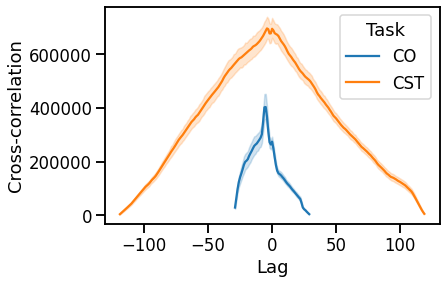

In [57]:
tangling_speed_corr = (
    cocst_tangling.groupby(['Task','trial_id'])
    .apply(
        lambda s: pd.Series({
            'Cross-correlation': correlate(s['LFADS tangling'],np.abs(s['X hand velocity'])),
            'Lag': correlation_lags(len(s['LFADS tangling']),len(s['X hand velocity'])),
        })
    )
    .explode(column=['Cross-correlation','Lag'])
    .set_index('Lag',append=True)
)

sns.lineplot(
    data=tangling_speed_corr,
    x='Lag',
    y='Cross-correlation',
    hue='Task',
)

This seems much more reasonable--a lag somewhere near zero, but probably to one side or the other (haven't looked at the actual location of the max). I would expect the tangling to lead the hand speed somehow.

I guess this means that maybe I should do a cross-correlation with hand acceleration also? Something for the future.